In [42]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyedflib import highlevel
import glob
import ghibtools as gh
import mne
import pandas as pd
from params import srate

In [2]:
def raw_to_da(patient):
    input_file = glob.glob(f'../data/{patient}/*.edf')[0]
    signals, signal_headers, header = highlevel.read_edf(input_file)
    srate = signal_headers[0]['sample_rate']
    chans = [chan_dict['label'] for chan_dict in signal_headers]
    eeg_chans = [ chan for chan in chans if 'EEG' in chan]
    eeg_chans_clean = [ chan.split(' ')[1] for chan in chans if 'EEG' in chan]
    physio_chans = ['ECG','Menton','EOGDt','EOGG','DEBIT','THERM'] 
    unit = signal_headers[0]['dimension']
    time = np.arange(0 , signals.shape[1] / srate , 1 / srate)
    dérivations = ['Fp2-C4' , 'C4-T4', 'T4-O2' , 'Fz-Cz' , 'Cz-Pz' , 'Fp1-C3', 'C3-T3', 'T3-O1', 'EOGDt-A1', 'EOGG-A2']
    duration = round(time[-1], 2)
    da = xr.DataArray(data = signals, dims = ['chan','time'] , coords = {'chan':chans , 'time':time}).assign_attrs({'srate':srate})
    return da

def eeg_mono_to_bipol(da, dérivations=['Fp2-C4' , 'C4-T4', 'T4-O2' , 'Fz-Cz' , 'Cz-Pz' , 'Fp1-C3', 'C3-T3', 'T3-O1', 'EOGDt-A1', 'EOGG-A2']):
    da_bipol = []
    for bipol in dérivations : 
        pole1, pole2 = bipol.split('-')[0] , bipol.split('-')[1]
        if pole1 in ['EOGDt','EOGG']:
            chan1 = pole1
            chan2 = f'EEG {pole2}'
        else:
            chan1 = f'EEG {pole1}'
            chan2 = f'EEG {pole2}'
        sig1 = da.loc[chan1,:]
        sig2 = da.loc[chan2,:]

        bipol_sig = sig1 - sig2
        da_bipol.append(bipol_sig)
    da_bipolaire = xr.concat(da_bipol, dim = 'chan')
    da_bipolaire = da_bipolaire.assign_coords({'chan':dérivations}).assign_attrs({'srate':da.attrs['srate']})
    return da_bipolaire

def da_to_mne_object(da):
    ch_names = list(da.coords['chan'].values)
    sfreq = da.attrs['srate']
    info = mne.create_info(ch_names, sfreq, ch_types='misc', verbose=None)
    raw = mne.io.RawArray(data = da.values, info=info, first_samp=0, copy='auto', verbose=None)
    return raw

def mne_viewer(patient):
    da_mono = raw_to_da(patient)
    da_bipol = eeg_mono_to_bipol(da_mono)
    mne_obj = da_to_mne_object(da_bipol)
    mne_obj.plot()
    plt.show()

def xr_viewer(patient, chan, start, stop):
    da_mono = raw_to_da(patient)
    da_bipol = eeg_mono_to_bipol(da_mono)
    srate = da_bipol.attrs['srate']
    sig = da_bipol.loc[chan,start:stop].values
    tf_sig = gh.tf(sig, srate=srate, f_start = 10, f_stop = 20, n_steps = 40, cycle_start = 4, cycle_stop = 10)
    print(tf_sig.coords['time'].values.shape)

    t = np.arange(0, sig.size/srate, 1/srate)
    f = tf_sig.coords['freqs'].values

    fig, axs = plt.subplots(nrows = 2)

    ax = axs[0]
    ax.plot(t, sig)

    ax = axs[1]
    ax.pcolormesh(t, f, tf_sig.values)

    plt.show()

In [3]:
patient = 'P1'

In [4]:
da_mono = raw_to_da(patient)
da_bipol = eeg_mono_to_bipol(da_mono)

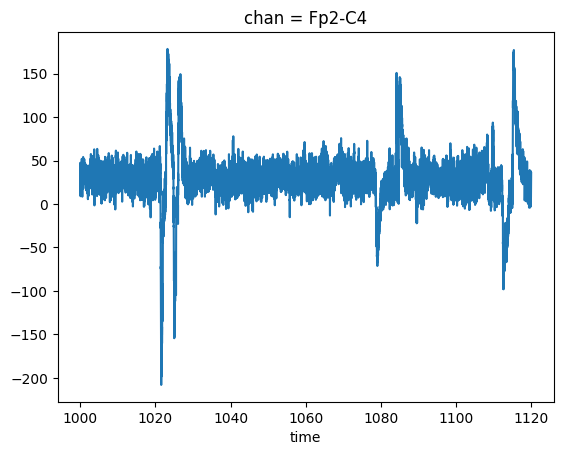

In [5]:
da_bipol.loc['Fp2-C4',1000:1120].plot()

In [6]:
chans = ['Fp2-C4','Fp1-C3','C4-T4','C3-T3']

In [7]:
da_tfs = None
for chan in chans:
    whole_sig = da_bipol.loc[chan,:].values
    whole_tf = gh.tf(whole_sig, srate=srate, f_start = 12, f_stop = 16, n_step = 20, cycle_start = 8, cycle_stop = 12)
    if da_tfs is None:
        da_tfs = gh.init_da({'chan':chans,'f':whole_tf.coords['freqs'].values, 't': whole_tf.coords['time'].values})
    da_tfs.loc[chan,:,:] = whole_tf.values


In [8]:
t_spindle = 8694
# t_spindle = 217
half_w = 2
start = t_spindle - half_w
stop = t_spindle + half_w
duration = stop-start

In [9]:
srate = da_bipol.attrs['srate']
t = da_bipol.coords['time'].loc[start:stop].values
tfs = {}
sigs = {}
sigs_filtered = {}
amps = {}
for chan in chans:
    sig = da_bipol.loc[chan, t].values
    sig_filtered = gh.filter_sig(sig, srate, 12, 16)
    amp = gh.get_amp(sig_filtered)
    sigs[chan] = sig
    sigs_filtered[chan] = sig_filtered
    amps[chan] = amp
    # da_tfs[chan] = gh.tf(sig, srate=srate, f_start = 12, f_stop = 15, n_step = 40, cycle_start = 5, cycle_stop = 15)

In [10]:
# t = list(tfs.values())[0].coords['time'].values
f = list(da_tfs.coords['f'].values)

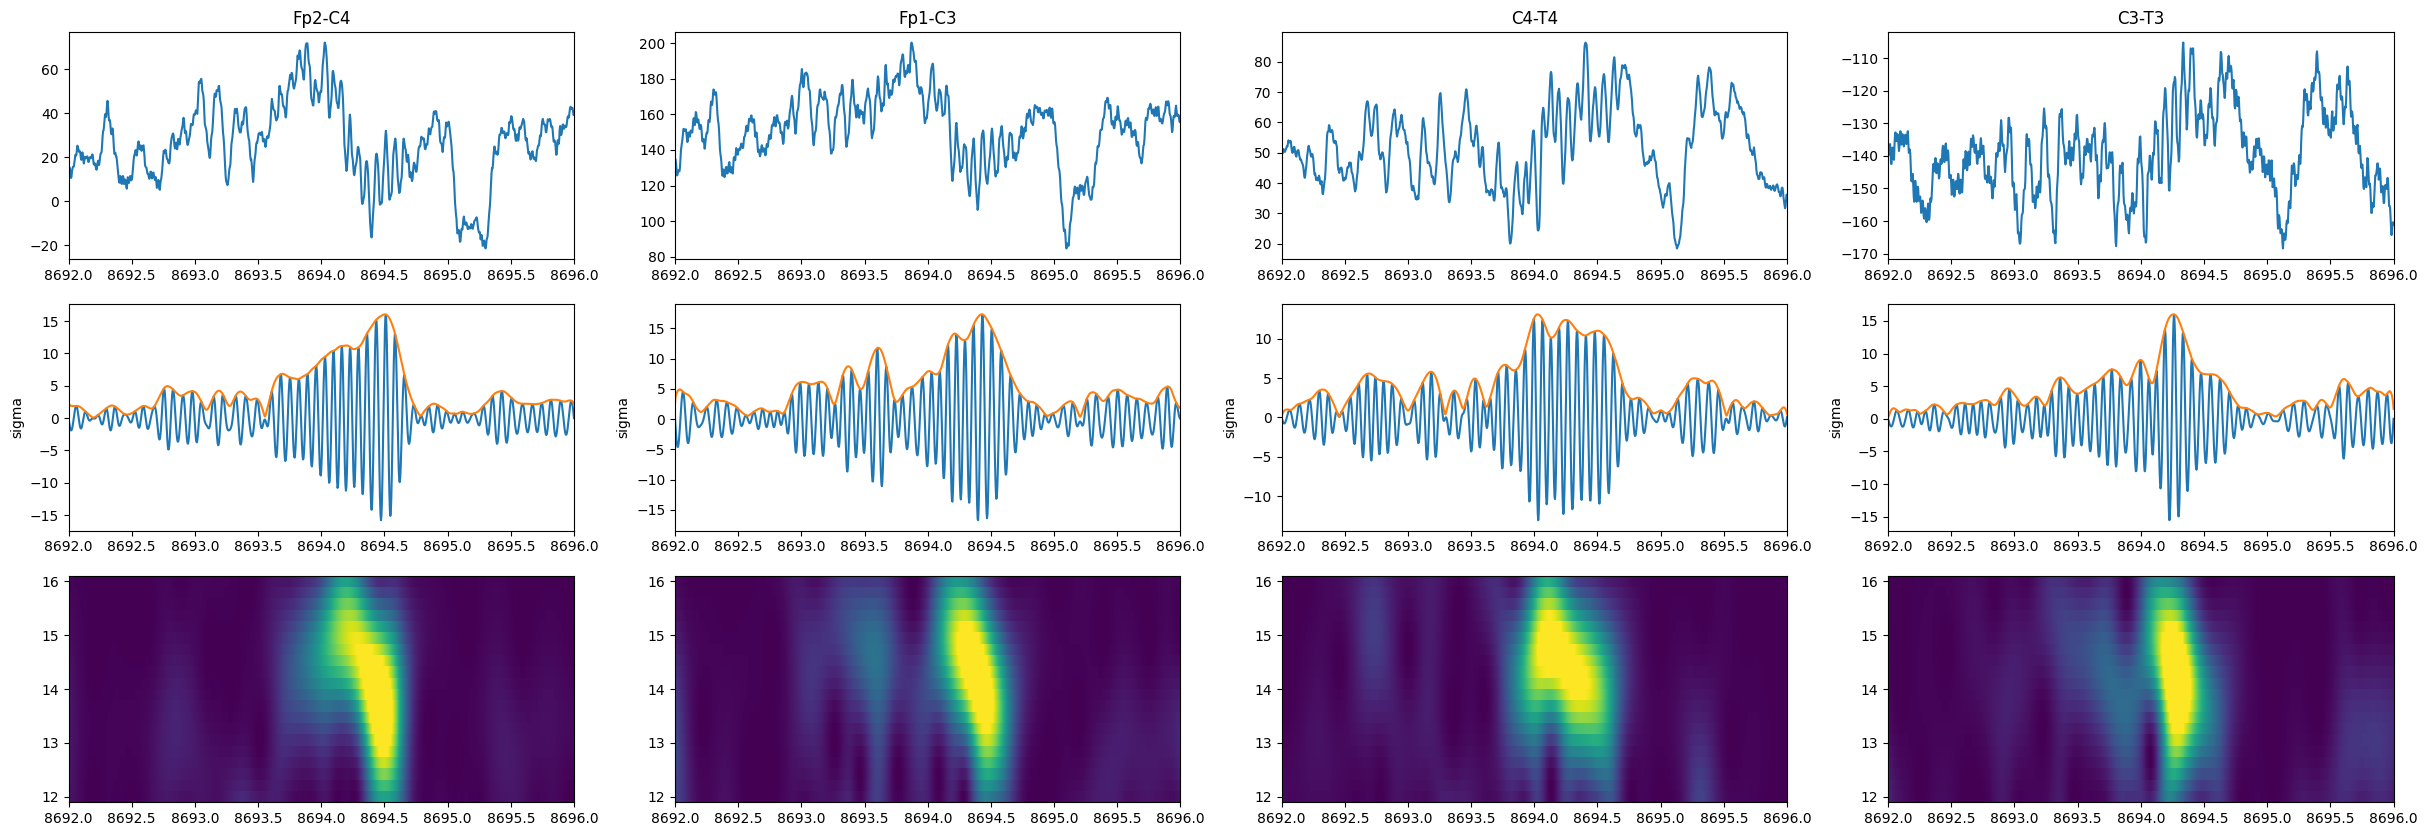

In [11]:
fig, axs = plt.subplots(nrows = 3, ncols = len(chans), figsize = (30,10))

for col, chan in enumerate(chans):

    ax = axs[0, col]
    ax.plot(t, sigs[chan])
    ax.set_xlim(start,stop)
    ax.set_title(chan)
    ax.set_ylabel('Raw amplitude')

    ax = axs[1, col]
    ax.plot(t, sigs_filtered[chan])
    ax.plot(t, amps[chan])
    ax.set_xlim(start,stop)
    ax.set_ylabel('Sigma amplitude')

    ax = axs[2, col]
    # ax.set_title(chan)
    data = da_tfs.loc[chan,:,start:stop]
    ax.pcolormesh(t, f , data.values, vmin = np.quantile(data, 0.02), vmax = np.quantile(data, 0.98))
    ax.set_xlim(start,stop)
    ax.set_ylabel('Freq [Hz]')
    ax.set_xlabel('Time [s]')

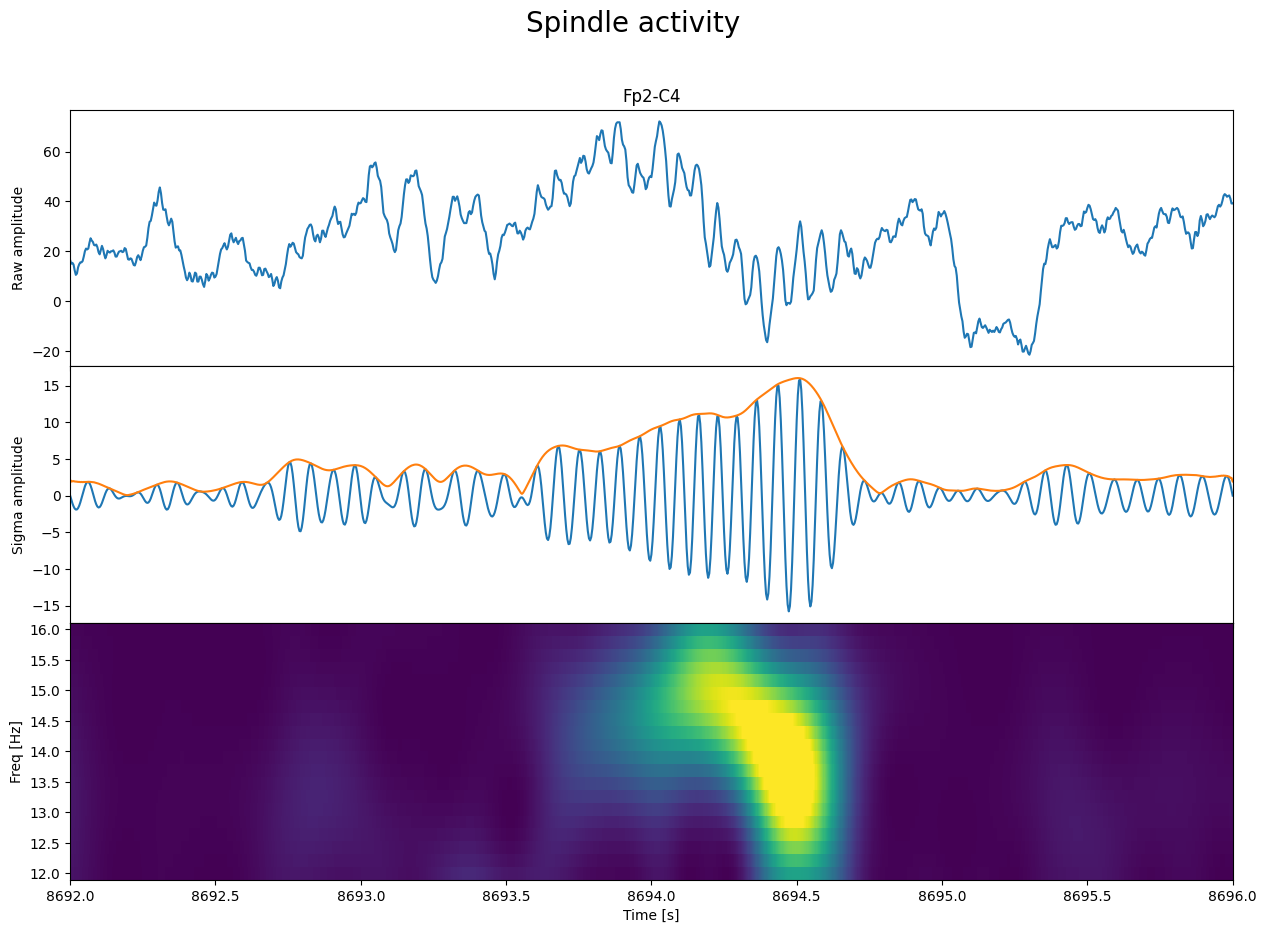

In [30]:
fig, axs = plt.subplots(nrows = 3, figsize = (15,10), sharex=True)
fig.suptitle('Spindle activity', fontsize =  20)
fig.subplots_adjust(hspace = 0)

chan = 'Fp2-C4'

ax = axs[0]
ax.plot(t, sigs[chan])
ax.set_xlim(start,stop)
ax.set_title(chan)
ax.set_ylabel('Raw amplitude')

ax = axs[1]
ax.plot(t, sigs_filtered[chan])
ax.plot(t, amps[chan])
ax.set_xlim(start,stop)
ax.set_ylabel('Sigma amplitude')

ax = axs[2]
# ax.set_title(chan)
data = da_tfs.loc[chan,:,start:stop]
im = ax.pcolormesh(t, f , data.values, vmin = np.quantile(data, 0.02), vmax = np.quantile(data, 0.98))
ax.set_xlim(start,stop)
ax.set_ylabel('Freq [Hz]')
ax.set_xlabel('Time [s]')

# plt.savefig('/crnldata/cmo/Etudiants/Valentin_G/presentations/figures_journée_sommeil_crnl_nov_2022/spindle_activity')